## STEP 1: Object detection

In [1]:
from ultralytics import YOLO
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random
from PIL import Image
import sys
from sentence_transformers import SentenceTransformer, util
from transformers import set_seed

sys.path.append('..')
from llm.prompts_generator import load_model
from llava_captioning.llava_descriptor import extract_images_from_grid
from sr_mechanism.sentence_evaluator import *

../generative_images/58_dog.png


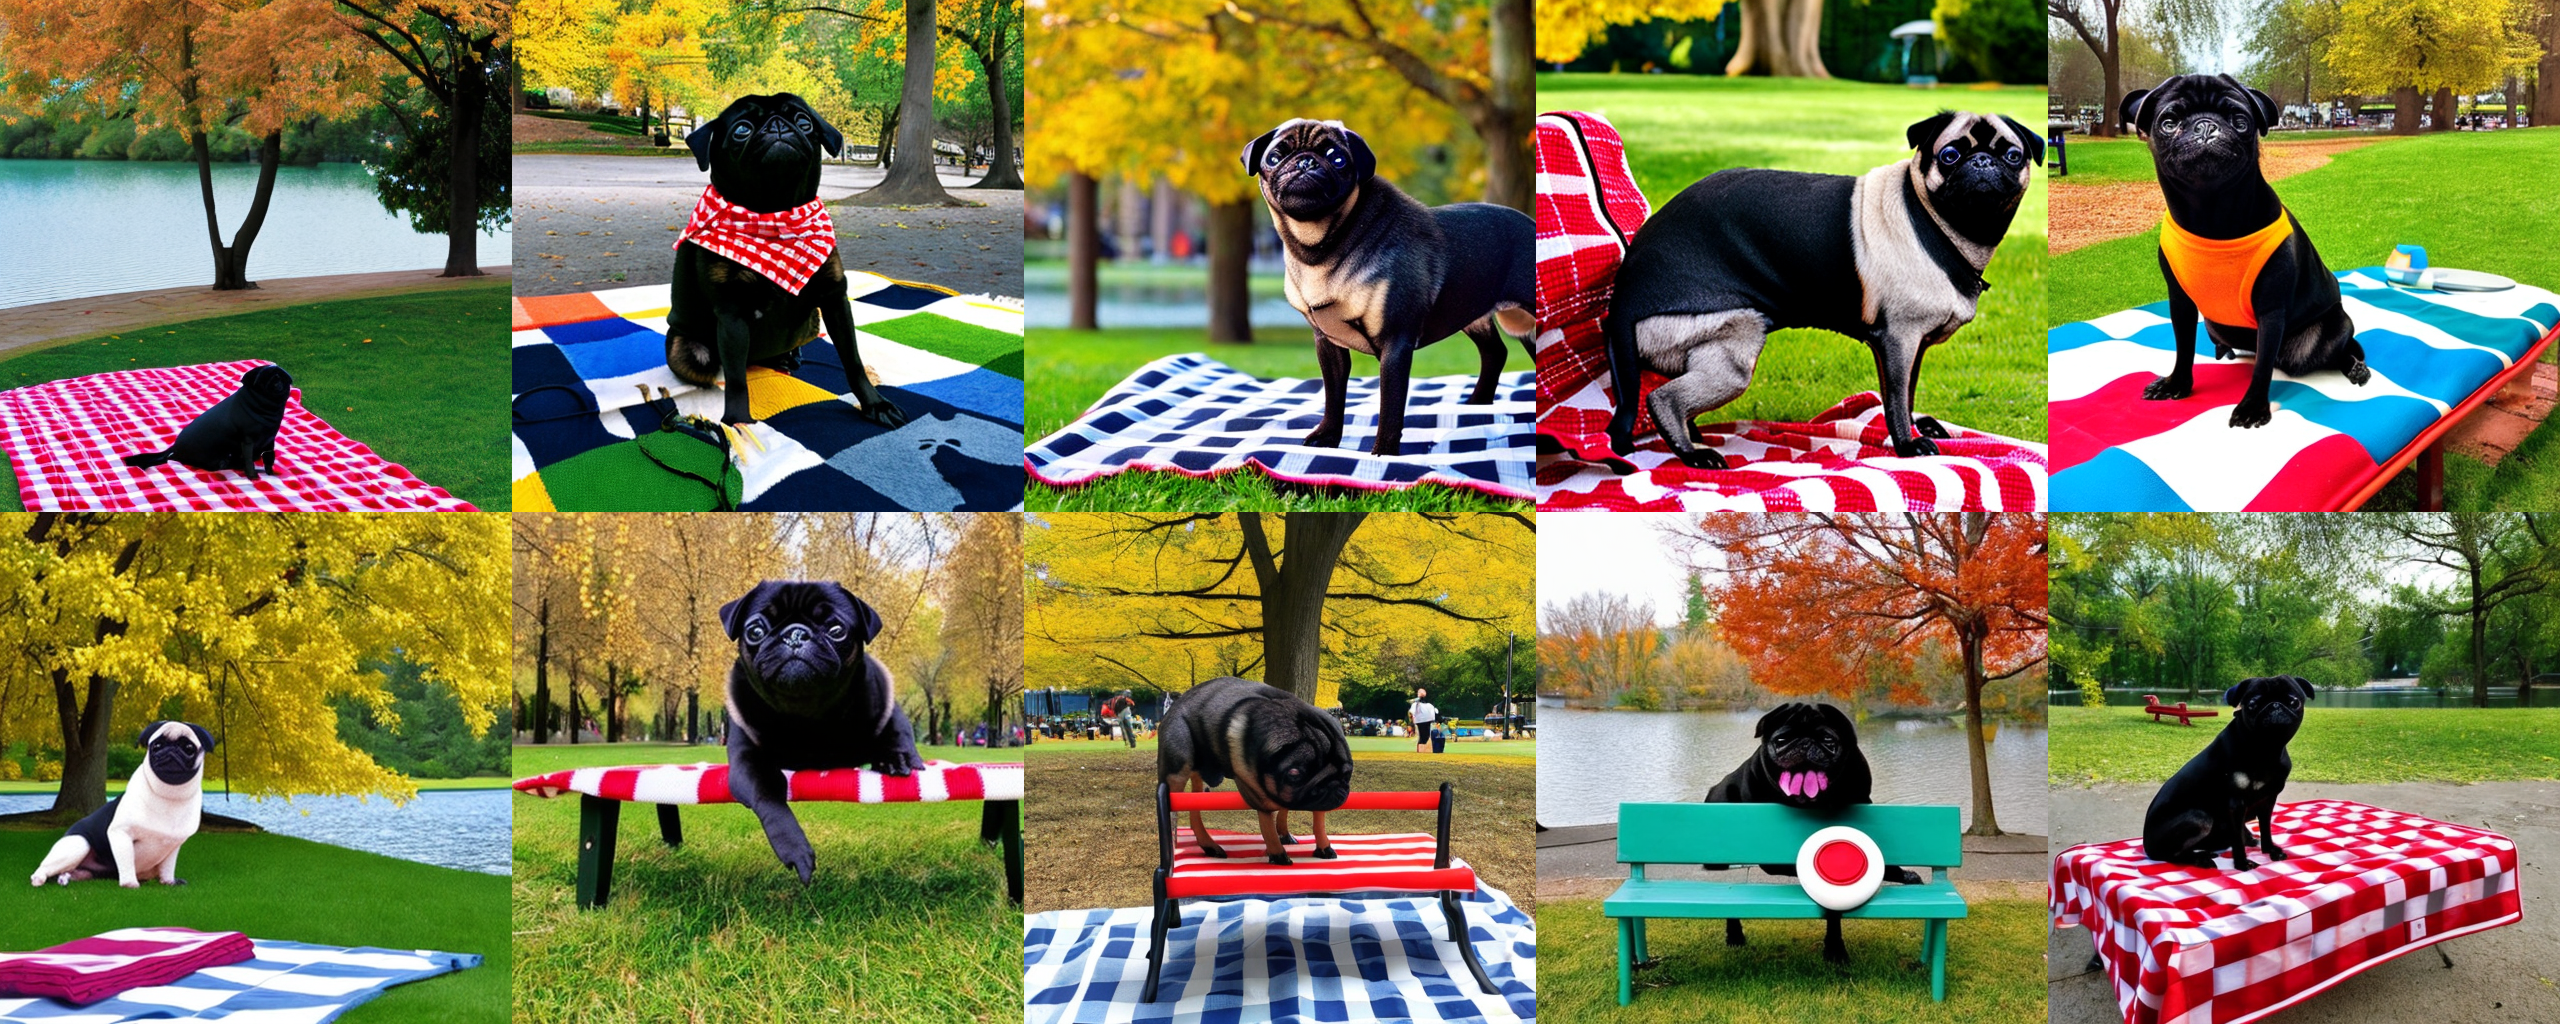

In [2]:
image_files = [f for f in os.listdir('../generative_images/') if f.endswith(('.png', '.jpg', '.jpeg'))]

img_file = os.path.join('../generative_images/', random.choice(image_files))
print(img_file)
image = Image.open(img_file)
image

## STEP 2: LLM self-judging

### let's prepare the data

In [3]:
def get_index_from_filename(filename):
    return int(filename.split('_')[0])

# Get the index from the chosen image file
indice = get_index_from_filename(os.path.basename(img_file))-1

# Rest of your code
prompt_list = []

with open('../generated_prompts.txt', 'r') as file:
    for line in file:
        class_, prompt = map(str.strip, line.split(';', 1))
        
        # Append [CLASS] and [PROMPT] to the 2D list
        prompt_list.append([class_, prompt])

if 0 <= indice < len(prompt_list):
    file_name = f"{indice + 1}_{prompt_list[indice][0]}.txt"
    
    # Read the content of the specified file
    with open(f'../generative_images_descriptions/{file_name}', 'r') as image_file:
        images_content = image_file.read()
        
    print(f'Class: {prompt_list[indice][0]}\n')
    print(f'Prompt: {prompt_list[indice][1]}\n')
    print(f'Image Content: \n{images_content}')
else:
    print(f"Index {indice} is out of range.")
    

Class: dog

Prompt: A black pug, sitting on a red and white checkered blanket in a park, a yellow tree, a blue lake, a green bench, a red frisbee.

Image Content: 
image 1: This image is most likely a realistic one. A black dog is sitting on a red and white checkered blanket on a grassy field near a tree. The dog appears to be relaxed and enjoying the outdoors. In the background, there is a body of water, possibly a lake or a pond. The scene is serene and peaceful, with the dog being the main focus of the image.
image 2: This image is most likely a realistic one. A black pug dog is sitting on a blanket, wearing a red and white bandana. The dog is looking at the camera, and its expression appears to be curious. The background features a park with trees and benches, where a few people can be seen sitting and enjoying the outdoors. The abnormality is that the dog's eyes look wrongly positioned.
image 3: This image is most likely a realistic one. A small black and white dog is sitting on a

## YOLO-world to detect the class

In [4]:
sys.path.append('..')
from sr_mechanism.yolo_filter import yolo_filtering

In [5]:
class_name = [prompt_list[indice][0]]
model = YOLO('yolov8l-world.pt') 
model.set_classes(class_name)
class_name

['dog']

In [6]:
result = yolo_filtering(image, class_name)

result


0: 640x640 1 dog, 24.5ms
Speed: 7.4ms preprocess, 24.5ms inference, 19.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 12.3ms
Speed: 1.7ms preprocess, 12.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 19.4ms
Speed: 4.1ms preprocess, 19.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 14.5ms
Speed: 2.1ms preprocess, 14.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 17

[]


0: 640x640 1 dog, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.0ms
Speed: 1.7ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 9.9

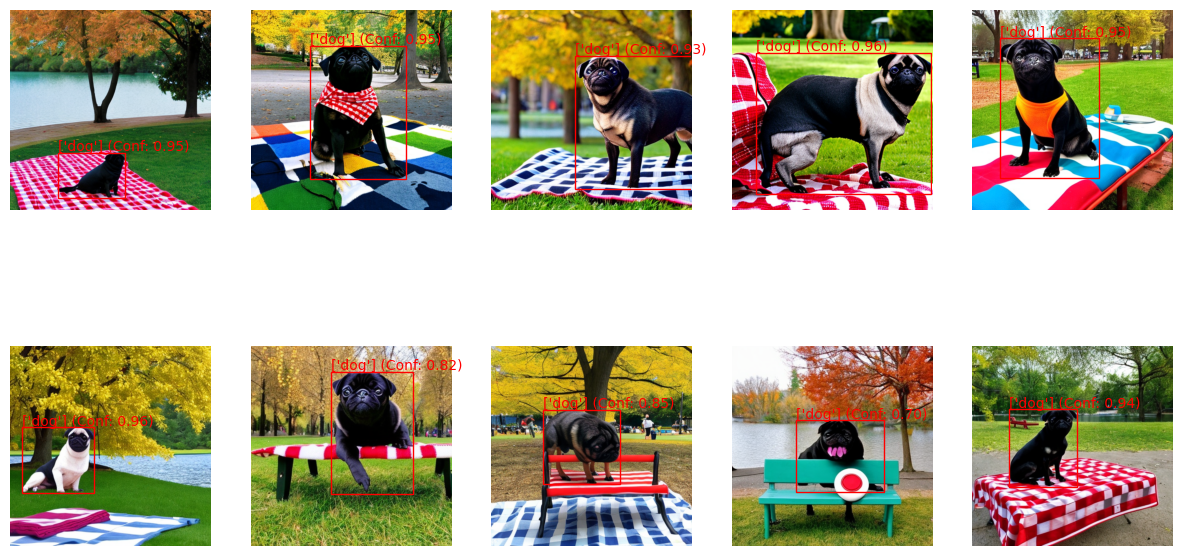

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

extracted_imgs = extract_images_from_grid(image, 2, 5)

fig, axs = plt.subplots(2, 5, figsize=(15, 8))
axs = axs.ravel()

no_detection = []

for i in range(10):
    res = model.predict(extracted_imgs[i], conf=0.1)
    
    if res[0].boxes.xyxy.cpu().numpy().any():
        for j, prediction in enumerate(res):
            boxes = prediction.boxes.xyxy.cpu().numpy()
            confidences = prediction.boxes.conf.cpu().numpy()

            for box, confidence in zip(boxes, confidences):
                x, y, w, h = box[:4]

                rect = patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')
                axs[i].add_patch(rect)

                # Display the class label and confidence value
                axs[i].text(x, y - 5, f"{class_name} (Conf: {confidence:.2f})", color='r')

        # Display the image without axes
        axs[i].imshow(extracted_imgs[i])
        axs[i].axis('off')
    else:
        no_detection.append(i+1)
        # Display the image without axes
        axs[i].imshow(extracted_imgs[i])
        axs[i].axis('off')

plt.show()


## Now LLM self-judging

In [8]:
#example of extracted lines and prompt
lines = images_content.split("\n")

let's remove the indices of images where no dog has been detected

In [9]:
lines_filtered = [line for i, line in enumerate(lines, start=1) if i not in result]
lines_filtered

['image 1: This image is most likely a realistic one. A black dog is sitting on a red and white checkered blanket on a grassy field near a tree. The dog appears to be relaxed and enjoying the outdoors. In the background, there is a body of water, possibly a lake or a pond. The scene is serene and peaceful, with the dog being the main focus of the image.',
 "image 2: This image is most likely a realistic one. A black pug dog is sitting on a blanket, wearing a red and white bandana. The dog is looking at the camera, and its expression appears to be curious. The background features a park with trees and benches, where a few people can be seen sitting and enjoying the outdoors. The abnormality is that the dog's eyes look wrongly positioned.",
 "image 3: This image is most likely a realistic one. A small black and white dog is sitting on a checkered blanket in a park. The dog is looking up, possibly at a tree or a person. The park is filled with trees, and there are several people scattered

In [10]:
scores_list = calculate_cosine_similarity_scores(prompt_list[indice][1], lines_filtered)

# Extract image numbers from lines_filtered
image_numbers = [int(line.split(":")[0].split()[-1]) for line in lines_filtered]

# Print image numbers and scores
for image_num, score in zip(image_numbers, scores_list):
    print(f"Image {image_num} - Score: {score}")


Image 1 - Score: 0.5878257751464844
Image 2 - Score: 0.706351637840271
Image 3 - Score: 0.5579330921173096
Image 4 - Score: 0.5491164922714233
Image 5 - Score: 0.5523807406425476
Image 6 - Score: 0.4678265452384949
Image 7 - Score: 0.632246196269989
Image 8 - Score: 0.35183185338974
Image 9 - Score: 0.4983717203140259
Image 10 - Score: 0.667068362236023


/home/safouane/miniconda3/envs/srt2i3/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


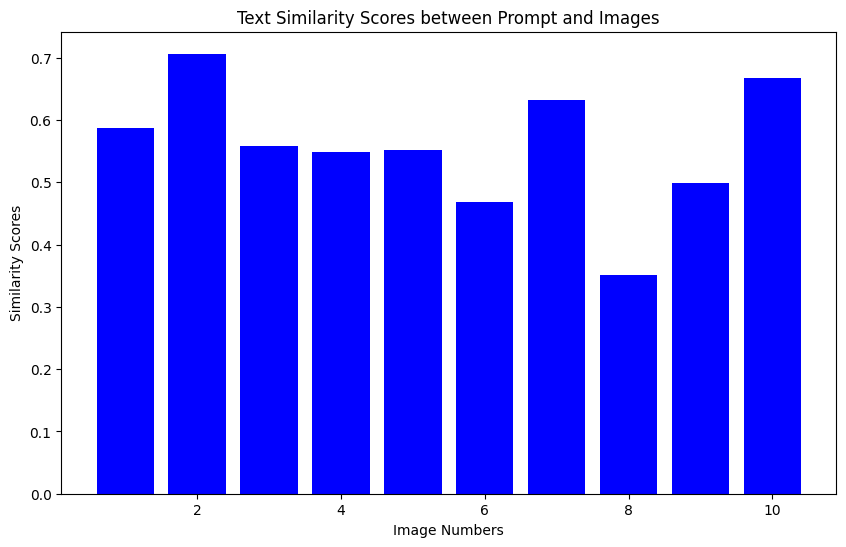

In [11]:
import matplotlib.pyplot as plt

# Plot the scores
plt.figure(figsize=(10, 6))
plt.bar(image_numbers, scores_list, color='blue')
plt.xlabel('Image Numbers')
plt.ylabel('Similarity Scores')
plt.title('Text Similarity Scores between Prompt and Images')
plt.show()

In [20]:
def keep_top_n_values(values, n=3):
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    top_indices = sorted_indices[:n]
    top_values = [values[i] for i in top_indices]
    return top_indices, top_values

top_indices, top_values = keep_top_n_values(scores_list, n=3)
for index, value in zip(top_indices, top_values):
    print(f"Image {image_numbers[index]} - Score: {value}")

Image 2 - Score: 0.706351637840271
Image 10 - Score: 0.667068362236023
Image 7 - Score: 0.632246196269989


In [21]:
def extract_top_images(images_content, top_indices):
    # Split the images_content into individual image descriptions
    image_descriptions = images_content.split('\n')
    
    # Extract and keep only the content of the top images
    top_images_content = []
    for index in top_indices:
        try:
            top_images_content.append(image_descriptions[index-1])
        except IndexError:
            print(f"IndexError: Index {index} out of range for image_descriptions. Total images: {len(image_descriptions)}")
    
    # Join the content back into a single string
    top_images_content_combined = '\n'.join(top_images_content)

    return top_images_content_combined

# Example usage
top_images_content = extract_top_images(images_content, [index + 1 for index in top_indices])

# Print the content of the top images
print(top_images_content)

image 2: This image is most likely a realistic one. A black pug dog is sitting on a blanket, wearing a red and white bandana. The dog is looking at the camera, and its expression appears to be curious. The background features a park with trees and benches, where a few people can be seen sitting and enjoying the outdoors. The abnormality is that the dog's eyes look wrongly positioned.
image 10: This image is most likely a realistic one. A black dog is sitting on a red and white checkered blanket, which is placed on a picnic table. The dog appears to be looking at the camera, and it is positioned in the center of the image. The background features a lush green park with a body of water, such as a lake or a pond, visible in the distance. There are also a few benches scattered around the park, providing seating for visitors. The overall atmosphere of the image is calm and serene, with the dog as the main focus.
image 7: This image is most likely a realistic one. A black pug dog is sitting 

In [22]:
model, tokenizer = load_model("TheBloke/Mistral-7B-Instruct-v0.2-AWQ")

prompt = ""
prompt_template=f'''{prompt}'''

tokens = tokenizer(
    prompt_template,
    return_tensors='pt'
).input_ids.cuda()

# Same as the "self-rewarding language models" paper
generation_params = {
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.95,
    "top_k": 40,
    "max_new_tokens": 512/4,
    "repetition_penalty": 1.1
}

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

SYSTEM_PROMPT = "<s>[SYS]Be critical in you analysis, very short and give importance to the realistic aspect of the image. Answer the question directly, justify your answer. do not give unecessary comments or discussions. Your answer should contain a single Image choice and don't talk about the other images.[/SYS]"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
prompt = f"{SYSTEM_PROMPT}<s>[INST]which one of those diffusion-based generated images <<{top_images_content}>> is accuratly respecting the Given PROMPT: '{prompt_list[indice][1]}'. Please pay attention to details in the description and prompt, analyse the common features, colors, backgrounds and select a single Image out of all image description. you only answer should be the Updated PROMPT based on your analysis and make it very concise and very descriptive to the selected image. Follow this template for you answer: 'Image X: PROMPT.' where X is the number of selected image and PROMPT is the updated PROMPT with detailed scene, colors, background, position, orientation.[/INST]"

tokens = tokenizer(
    prompt,
    return_tensors='pt'
).input_ids.cuda()

generation_output = model.generate(
    tokens,
    pad_token_id=tokenizer.eos_token_id,
    streamer=streamer,
    **generation_params
)

Image 2: A black pug dog sitting on a red and white checkered blanket in a park, with a mispositioned gaze.


In [50]:
prompt = f"{SYSTEM_PROMPT}<s>[INST]which one of those diffusion-based generated images <<{top_images_content}>> is accuratly respecting the Given PROMPT: '{prompt_list[indice][1]}'. Please pay attention to details in the description and prompt, analyse the common features, colors, backgrounds and select a single Image out of all image description. you only answer should be the Updated PROMPT based on your analysis and make it very concise and very descriptive to the selected image. Follow this template for you answer: 'Image X: PROMPT.' where X is the number of selected image and PROMPT is the updated PROMPT with detailed scene, colors, background, position, orientation.[/INST]"

tokens = tokenizer(
    prompt,
    return_tensors='pt'
).input_ids.cuda()

generation_output = model.generate(
    tokens,
    pad_token_id=tokenizer.eos_token_id,
    **generation_params
)

In [55]:
prompt = f"{SYSTEM_PROMPT}<s>[INST]which one of those image descriptions <<{top_images_content}>> is the most realistic and accuratly respecting the Given PROMPT: '{prompt_list[indice][1]}'. Please pay attention to details in the description and prompt, analyse the common features, colors, backgrounds and select a single Image out of all image description. you only answer should be the Updated PROMPT based on your analysis and make it very concise and very descriptive to the selected image. Follow this template for you answer: 'Image X: PROMPT.' where X is the number of selected image and PROMPT is the updated PROMPT with detailed scene, colors, background, position, orientation.[/INST]"

tokens = tokenizer(
    prompt,
    return_tensors='pt'
).input_ids.cuda()

generation_output = model.generate(
    tokens,
    pad_token_id=tokenizer.eos_token_id,
    **generation_params
)
generated_prompts = tokenizer.decode(generation_output[0])
generated_prompts

"<s><s> [SYS]Be critical in you analysis, very short and give importance to the realistic aspect of the image. Answer the question directly, justify your answer. do not give unecessary comments or discussions. Your answer should contain a single Image choice and don't talk about the other images.[/SYS]<s> [INST]which one of those image descriptions <<image 5: This image is most likely a realistic one. Three cats are sitting on a blue couch, looking out the window. The couch is positioned in front of a large window, allowing the cats to enjoy the view. The cats are sitting on pillows, which are placed on the couch. The background features a potted plant, adding a touch of greenery to the scene. The image is well-lit, with natural light coming through the window. The abnormality is that the cats' eyes appear to be mismatched, giving them a peculiar look.\nimage 3: This image is most likely a realistic one. Two cats are sitting on a window sill, looking out at the street below. The cats a

In [25]:
generated_prompts = tokenizer.decode(generation_output[0])
generated_prompts

"<s><s> [SYS]Be critical in you analysis, very short and give importance to the realistic aspect of the image. Answer the question directly, justify your answer. do not give unecessary comments or discussions. Your answer should contain a single Image choice and don't talk about the other images.[/SYS]<s> [INST]which one of those diffusion-based generated images <<image 2: This image is most likely a realistic one. A black pug dog is sitting on a blanket, wearing a red and white bandana. The dog is looking at the camera, and its expression appears to be curious. The background features a park with trees and benches, where a few people can be seen sitting and enjoying the outdoors. The abnormality is that the dog's eyes look wrongly positioned.\nimage 10: This image is most likely a realistic one. A black dog is sitting on a red and white checkered blanket, which is placed on a picnic table. The dog appears to be looking at the camera, and it is positioned in the center of the image. Th

In [26]:
start_marker = '[/INST]'
end_marker = ':'

start_index = generated_prompts.find(start_marker) + len(start_marker)
end_index = generated_prompts.find(end_marker, start_index)

selected_image_description = generated_prompts[start_index:end_index].strip()

print(selected_image_description)


Image 2


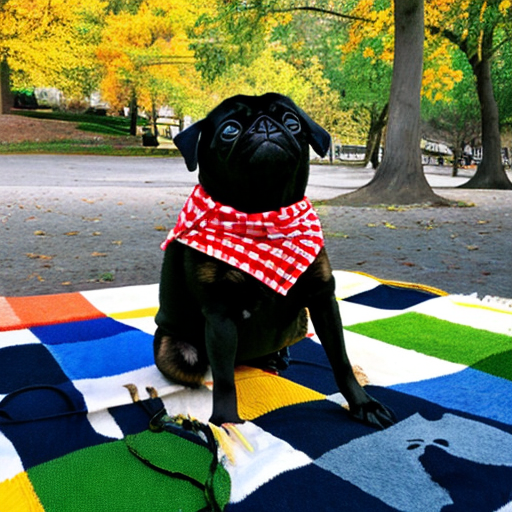

In [51]:
images = extract_images_from_grid(image, 2, 5)

image_nb = selected_image_description.split()[-1]

img = images[int(image_nb)-1]
img


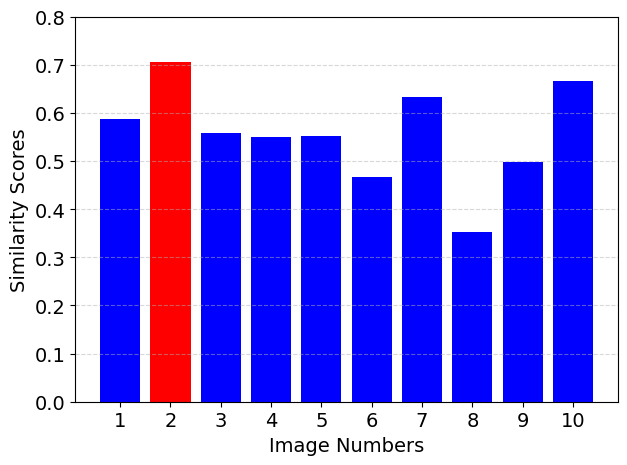

In [48]:
import matplotlib.pyplot as plt

# Assuming you have defined image_numbers, scores_list, and image_nb before this point

# Convert image_nb to the same data type as the elements in image_numbers
image_nb = type(image_numbers[0])(image_nb)

# Create a list of colors for each bar
bar_colors = ['red' if image_number == image_nb else 'blue' for image_number in image_numbers]

# Set the font size
plt.rcParams.update({'font.size': 14})

# Plot the scores with the specified colors
plt.figure(figsize=(7, 5))
plt.bar(image_numbers, scores_list, color=bar_colors)
plt.xlabel('Image Numbers')
plt.ylabel('Similarity Scores')

# Set x ticks from 1 to 10
plt.xticks(range(1, 11))

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Set y-axis limits between 0.0 and 0.8
plt.ylim(0.0, 0.8)

plt.savefig('similarity_score.pdf')

plt.show()
